In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM, GenerationConfig
import accelerate
import torch
import csv
import time
import os
import json
import inspect

In [2]:
from transformers import logging

In [3]:
logging.disable_progress_bar()

In [4]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:1"

model_name = "Qwen/Qwen2.5-7B-Instruct-1M"

padding_side='left'

model = AutoModelForCausalLM.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, )
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, 
                                          torch_dtype=torch.float16, padding_side=padding_side)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
mycache = model._get_cache()

TypeError: GenerationMixin._get_cache() missing 5 required positional arguments: 'cache_implementation', 'batch_size', 'max_cache_len', 'device', and 'model_kwargs'

<method-wrapper '__getattribute__' of Qwen2ForCausalLM object at 0x7f37695a60f0>

In [5]:
tokenizer.pad_token = tokenizer.eos_token
add_generation_prompt = True
padding = True
return_tensors = "pt"

In [6]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)

generation_config.output_hidden_states = True
generation_config.return_dict_in_generate = True
#generation_config.output_logits = True
generation_config.max_new_tokens = 10000
generation_config.pad_token_id = tokenizer.pad_token_id
#generation_config.use_cache = False

In [7]:
print(f"QWEN GenerationConfig. \n\n \
Generation Strategy: \n \
\t- do_sample: {generation_config.do_sample} \n \
\t- num_beams: {generation_config.num_beams} \n\n \
Model Output Logit manipulation: \n \
\t- top-k: {generation_config.top_k} \n \
\t- top-p: {generation_config.top_p} \n \
\t- min-p: {generation_config.min_p} \n \
\t- temperature: {generation_config.temperature}\n")

QWEN GenerationConfig. 

 Generation Strategy: 
 	- do_sample: True 
 	- num_beams: 1 

 Model Output Logit manipulation: 
 	- top-k: 20 
 	- top-p: 0.8 
 	- min-p: None 
 	- temperature: 0.7



In [8]:
#     {"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."}]

sentences=[{'role': "user",
           "content": "Hi ChatGPT. Do you think you can tell me the sum of a and b?",
           "context": "a=10, b=20"}]
print(tokenizer.decode(tokenizer.apply_chat_template(sentences, 
                                                     padding=padding, 
                                                     return_tensors=return_tensors, 
                                                     add_generation_prompt=add_generation_prompt)[0]))

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Hi ChatGPT. Do you think you can tell me the sum of a and b?<|im_end|>
<|im_start|>assistant



In [9]:
sentences = [[{"role": "user", "content": "Hi ChatGPT. Do you think you could run a dungeons and dragons campaign for me that I can play as you do it? You should be able to generate the story as it goes. 3 / 3"}]]*10

In [13]:
inputs = tokenizer.apply_chat_template(sentences, padding=padding, return_tensors=return_tensors, 
                                       add_generation_prompt=add_generation_prompt)

In [14]:
inputs.shape

torch.Size([10, 63])

In [15]:
print(tokenizer.batch_decode(inputs)[3])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Hi ChatGPT. Do you think you could run a dungeons and dragons campaign for me that I can play as you do it? You should be able to generate the story as it goes. 3 / 3<|im_end|>
<|im_start|>assistant



In [16]:
tmp_dev = "cuda" if device_str == "auto" else device_str
t_start = time.time()
output = model.generate(inputs.to(tmp_dev), generation_config=generation_config)
print(f"Generation took {time.time()-t_start} sec")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Generation took 23.499037981033325 sec


In [17]:
type(output)

transformers.generation.utils.GenerateDecoderOnlyOutput

In [18]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [19]:
output[0].shape

torch.Size([10, 707])

In [20]:
output[0].shape[1] - inputs.shape[1]

644

In [21]:
len(output['hidden_states'])

644

In [22]:
len(output['hidden_states'][0])

29

In [38]:
output['hidden_states'][0][0].shape

torch.Size([10, 63, 3584])

#### Check equivalence between two elements in the batch

In [43]:
output['hidden_states'][0][0][0].shape

torch.Size([63, 3584])

In [46]:
import numpy as np 
for i in range(0, output['hidden_states'][0][0].shape[0]-1):
    print(torch.all(output['hidden_states'][0][0][i] == output['hidden_states'][0][0][i+1]))


tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


##### Hence -> The hidden states are equal across all elements of the minibatch!

In [24]:
output['hidden_states'][0][0].element_size() * output['hidden_states'][0][0].nelement() / 1e6

4.51584

In [25]:
output['sequences'].dtype

torch.int64

#### Get the length of each response (remove padding tokens)

In [47]:
def get_len_out_tokens_batch(output_seq, tokenizer):
    assert type(output_seq) == torch.Tensor, "ERROR: output must a tensor representing the batch of token outputs"
    # Create a tensor with same size as output filled with the pad_token_id
    eos_mask = torch.ones(output_seq.shape, dtype=output_seq.dtype).to(output_seq.device)*tokenizer.pad_token_id
    # Return sum of all values of output along batch axis
    return torch.sum(output_seq != eos_mask, dim=1)

In [48]:
out_lengths = get_len_out_tokens_batch(output['sequences'], tokenizer)
print(f"Length of the outputs (in # of tokens):\n{out_lengths}")

Length of the outputs (in # of tokens):
tensor([233, 248, 190, 486, 488, 226, 400, 204, 704, 191], device='cuda:0')


In [49]:
torch.argmax(out_lengths).item()

8

In [50]:
torch.argmin(out_lengths).item()

2

In [51]:
max_idx = torch.argmax(out_lengths).item()
tokenizer.decode(output['sequences'][max_idx][inputs.shape[1]:out_lengths[max_idx].item()-1])

'That sounds like an exciting idea! While I can certainly help you create and guide a Dungeons & Dragons (D&D) campaign, it\'s important to note that I can\'t actually *play* with you in real-time. However, I can certainly help you create the story, generate encounters, and guide the narrative as you go along.\n\nHere’s how we can work together:\n\n### 1. **Setting the Scene:**\n   - **World**: What kind of world are we in? Fantasy, high-fantasy, dark fantasy, or something else?\n   - **Campaign Style**: Are we going for a long-term adventure, a series of one-shots, or a specific genre (e.g., horror, comedy)?\n   - **Player Characters (PCs)**: Who are your characters? What classes, races, backgrounds, and abilities do they have?\n\n### 2. **Plot Hook:**\n   - **Starting Quest**: What brings the PCs together? Is there a mysterious artifact, a missing person, or a looming threat?\n   - **First Encounter**: What happens when they enter the world of the game? A strange event, a meeting wit

In [52]:
torch.argmax(out_lengths).item()

8

In [53]:
out_lengths.dtype

torch.int64

In [54]:
# create list by dynamic slicing across the first tensor dimension
[output['sequences'][i, inputs.shape[-1]:out_lengths[i].item()] for i in range(len(out_lengths))][0:3]

[tensor([77045,     0,   358,  4172,   387,  6247,   311,  1492,   498,  1526,
           264, 93001,   609, 48009, 11297, 17943,    13,  8704,   582,  2299,
          6825,   432,   389,   279, 11466,    11,  1077,   594,  5695,   264,
          2421, 31774,  1447,    16,    13,  3070, 15400, 95518, 10967,  1558,
           697, 17943,  1896,  1992,    30, 21149,   315,   264,  3151,  3728,
           476,  1879,   320,    68,  1302,  2572,   264, 41008, 18378, 25079,
            11,   264,  1736, 45156, 68648, 40321, 18123,    11,   458, 13833,
         37239,    11,  4992, 74203,    17,    13,  3070, 37489, 95518,  3555,
          3093,   315,  5766,   686,   582,   387,  5619,    30,  4841,   498,
           387,  5619,   438,   825,   315,   279, 87713,    11,   476,  1035,
           498,  1075,   311,  2524,  5248,  5766,  1939,    18,    13,  3070,
         39992, 95518,  3555,   374,   279,  1887,  5795,   315,   279, 17943,
            30,  8713,   807, 10887, 31626,    11,  

In [55]:
output_str = tokenizer.batch_decode([output['sequences'][i, inputs.shape[-1]:out_lengths[i].item()] for i in range(len(out_lengths))], skip_special_tokens=False)
ctr = 0 
for i, elem in enumerate(output_str):
    print(f"ELEMENT {i}:\n{elem}")
    print(f"CHAR-SIZE OF ELEM: {len(elem)}")
    print("============================================================\n")

ELEMENT 0:
Absolutely! I'd be happy to help you through a Dungeons & Dragons-style adventure. Since we're creating it on the fly, let's establish a few basics:

1. **Setting**: Where does your adventure take place? Think of a specific location or world (e.g., a medieval fantasy kingdom, a post-apocalyptic wasteland, an ancient ruin, etc.).

2. **Characters**: What kind of characters will we be playing? Will you be playing as one of the adventurers, or would you like to control multiple characters?

3. **Goal**: What is the main goal of the adventure? Are they seeking treasure, trying to stop a villain, exploring an ancient ruin, or something else entirely?

Once we have these details, we can dive right into the story! Let me know what you'd like, and we can get started.
CHAR-SIZE OF ELEM: 769

ELEMENT 1:
Absolutely! I'd love to help you with that. Let's get started by setting up some basics:

1. **Setting**: Where would you like the campaign to take place? For example, a fantasy world,

In [234]:
torch.mean(out_lengths.float()), torch.max(out_lengths.float()), torch.std(out_lengths.float())

(tensor(104.9000, device='cuda:0'),
 tensor(133., device='cuda:0'),
 tensor(20.0413, device='cuda:0'))

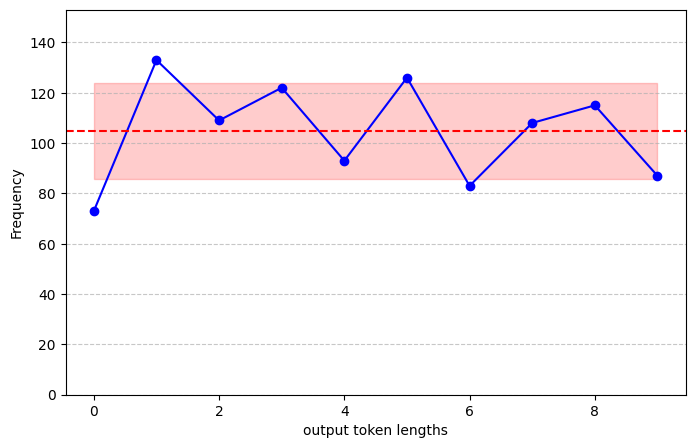

In [245]:
import matplotlib.pyplot as plt
import torch
import numpy as np

plot_data = out_lengths.cpu().numpy()
plot_std = np.std(plot_data)
plot_mean = np.mean(plot_data)

# Plot histogram
plt.figure(figsize=(8, 5))
#plt.hist(out_lengths.cpu().numpy(), bins=10, edgecolor='black', alpha=0.7)
plt.plot(range(len(plot_data)), plot_data, marker='o', linestyle='-', color='b', label="N values")
plt.axhline(y=plot_mean, color='r', linestyle='--', label="mean")
plt.fill_between(range(len(plot_data)), plot_mean-plot_std, plot_mean+plot_std, color='red', alpha=0.2, label="std-dev")

plt.xlabel("output token lengths")
plt.ylabel("Frequency")
plt.ylim(0, max(plot_data)+20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [250]:
output_forward = model.forward(inputs.to(device_str), output_hidden_states = True)

In [251]:
output_forward.__dict__.keys()

dict_keys(['loss', 'logits', 'past_key_values', 'hidden_states', 'attentions'])

In [252]:
len(output_forward.hidden_states)

33

In [258]:
# CHECK IF THE HIDDEN STATES FROM "forward" and "generate" are the same for the first token generation attempt

all([torch.all(output['hidden_states'][0][i] == output_forward['hidden_states'][i]).to('cpu') 
     for i in range(model.config.num_hidden_layers)])

True

torch.Size([4, 118])

In [85]:
torch.sum(tmp != out_eos_mask, dim=1) + 1

tensor([109,  89,  93, 118], device='cuda:0')

tensor([[ 3066,   416,   508,   472, 15654,   298,   272,  5264,  8462,   302,
          3926,   486,  4676,   297,   264,  4610,   442, 21158,  1069, 28723,
           661,   349,   272, 11839,  1007, 15043,   302,  1545,  1179,   369,
          6881, 12799,   346, 28725,  1671,  4681,  7394,   442, 12782, 28723,
         24640, 28725,   378, 14657,  7484,  1871,   442,  5823,   369, 11117,
         11976,   624, 28742, 28713,  1411, 28725,   771, 28725,   442,  9391,
         28723,  3066,   416,   508,   472,   541,  1388,  1287,  6967, 28725,
          1259,   390,  5283,   272,  1103,  1338, 28725,  7484,   264,  7918,
          9234, 28725,   442,  5191,   288,   264,   633,  5701, 28723,   661,
           349,   272,  4610,  8318,   369,  8681,   298,  5278, 18014,   304,
          7263,  5843,   813,  4621,   297, 12799,  4342, 28723,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2],
        [ 3066,   416,   508,   472,   349,   272,  5264,  8462, 

In [52]:
for elem in output_str:
    print(f"{elem}")
    print(f"CHAR-SIZE OF ELEM: {len(elem)}")
    print("============================================================\n")

Serendipity refers to the occurrence and development of events by chance, in a happy or beneficial way. It is the fortunate discovery of something valuable, unexpected or pleasing. Serendipity often leads to opportunities and good outcomes, and can play a significant role in shaping one's life or experiences.</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
CHAR-SIZE OF ELEM: 522

Serendipity is the occurrence and development of events by chance in a happy or beneficial way. It is the discovery of something good or useful that happens unexpectedly, often in a surprising way. Serendipity can take many forms, such as finding a new job opportunity, meeting someone important, or stumbling upon a solution to a problem. It is seen as a stroke of luck or good fortune, and is often valued as a positive force in our lives.</s></s></s>

In [6]:
# sentences = ["What is serendipity? Explain in one sentence.", 
#              "When was Kennedy president?", 
#              "Write me a to-do list.", 
#              "Alice has 5 apples and Bob has 3. If Bob takes 1 apple from Alice, how many apples do both have at the end?"]

# sentences = ["What is serendipity? Explain in maximum one paragraph."]*4 
sentences = [{"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."}]
print(tokenizer.decode(tokenizer.apply_chat_template(sentences)))#, add_generation_prompt=True)))

<bos><start_of_turn>user
What is serendipity? Explain in maximum one paragraph.<end_of_turn>



In [11]:
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(device_str)

In [12]:
inputs

{'input_ids': tensor([[     2,   1841,    603,   1369, 197762, 235336,  36576,    575,   7725,
            974,  16957, 235265]], device='cuda:1'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:1')}

In [86]:
tokenizer.max_len_single_sentence

1000000000000000019884624838655

In [53]:
print(tokenizer.get_chat_template())

{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '
' + message['content'] | trim + '<end_of_turn>
' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model
'}}{% endif %}


In [54]:
sentences = [
    {"role": "user", "content": ""},
    {"role": "assistant", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is serendipity? Explain in maximum one paragraph."},
]
print(tokenizer.decode(tokenizer.apply_chat_template(sentences)))

<bos><start_of_turn>user
<end_of_turn>
<start_of_turn>model
You are a helpful assistant.<end_of_turn>
<start_of_turn>user
What is serendipity? Explain in maximum one paragraph.<end_of_turn>



In [58]:
inputs = tokenizer.apply_chat_template(sentences, padding=True, return_tensors="pt").to(device_str)

In [59]:
inputs

tensor([[     2,    106,   1645,    108,    107,    108,    106,   2516,    108,
           2045,    708,    476,  10055,  20409, 235265,    107,    108,    106,
           1645,    108,   1841,    603,   1369, 197762, 235336,  36576,    575,
           7725,    974,  16957, 235265,    107,    108]], device='cuda:1')

In [57]:
inputs = tokenizer(tokenizer.decode(tokenizer.apply_chat_template(sentences)), return_tensors="pt").to(device_str)

In [76]:
inputs.shape[1]

33

In [60]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)
#generation_config.output_hidden_states = True
#generation_config.return_dict_in_generate = True
#generation_config.output_logits = True
generation_config.max_new_tokens = 10000
generation_config.pad_token_id = tokenizer.pad_token_id
generation_config.use_cache = True


In [62]:
output = model.generate(inputs, generation_config=generation_config)

In [73]:
output

tensor([[     2,    106,   1645,    108,    107,    108,    106,   2516,    108,
           2045,    708,    476,  10055,  20409, 235265,    107,    108,    106,
           1645,    108,   1841,    603,   1369, 197762, 235336,  36576,    575,
           7725,    974,  16957, 235265,    107,    108, 235287,   3191, 197762,
         235287,    603,    573,  28635,    578,   3505,    576,   5562,    731,
           7068,    575,    476,   4915,    689,  26014,   1703, 235265,   1165,
         235303, 235256,   1105,  10488,   2775,  14222,    689,   7103,  71024,
         235269,   3695,   1593,    476,  42006,  60154, 235265, 235248,    110,
            107]], device='cuda:1')

In [78]:
output_str = tokenizer.batch_decode(output[:,inputs.shape[1]:], skip_special_tokens=True)

In [82]:
for elem in output_str:
    print(f"{elem}")
    print(f"SIZE OF ELEM: {len(elem)}")
    print("\n")

*Serendipity* is the occurrence and development of events by chance in a happy or beneficial way. It's about finding something valuable or interesting unexpectedly, often through a fortunate coincidence. 



SIZE OF ELEM: 207




In [83]:
tokenizer.max_len_single_sentence

1000000000000000019884624838655

In [21]:
def tokenize_and_infer(model, generation_config, prompt):
    inputs = tokenizer(prompt, return_tensors='pt')
    input_ids = inputs.input_ids.to('cuda')
    output = model.generate(input_ids, 
                            generation_config=generation_config, 
                            attention_mask=inputs.attention_mask)
    # Return the length of the tokenized input, and the output from "generate"
    return len(inputs.input_ids[0]), output

In [32]:
input_len, output = tokenize_and_infer(model, generation_config, sentences[0])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [111]:
out_tokens = len(output.logits)
print(out_tokens)

27


In [105]:
output['sequences'][0]

tensor([128000,   3923,    374,   1446,    408,    575,    488,     30,  83017,
           304,    832,  11914,     13,   8409,    408,    575,    488,    374,
           279,  32659,    315,   9455,   2555,  15525,    477,  50189,    994,
           499,   3325,   1755,    433,     11,   3629,   1555,   6140,    477,
         16907,  13463,     13, 128009], device='cuda:0')

In [106]:
out_text = tokenizer.decode(output['sequences'][0][input_len:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [107]:
out_text

' Serendipity is the occurrence of finding something valuable or delightful when you least expect it, often through chance or unexpected circumstances.'

In [108]:
input_len

13

In [33]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [63]:
len(output.logits)

27

In [77]:
output.logits[0].shape

torch.Size([1, 128256])

In [135]:
len(output.hidden_states[2][0])

1

In [136]:
output.hidden_states[2][0].shape

torch.Size([1, 1, 2048])

In [ ]:
len(output['hidden_states'])

In [84]:
for elem in tokenizer.batch_decode(output['sequences'], skip_special_tokens=True, clean_up_tokenization_spaces=False): 
    print(f"###########################\n{elem}")

###########################
What is serendipity? Explain in one sentence. Serendipity is the occurrence of finding something valuable or delightful when you least expect it, often through chance or unexpected circumstances.


In [85]:
len(output['sequences'][0])

40

In [76]:
torch.all(output.hidden_states[0][-1][0,-1,:] == output.logits[0])

RuntimeError: The size of tensor a (2048) must match the size of tensor b (128256) at non-singleton dimension 1

In [52]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [3]:
messages = [
    {"role": "system",
     "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", 
     "content": "How many helicopters can a human eat in one sitting?"},
]

In [4]:
tokenizer.apply_chat_template(messages, tokenize=False)

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are a friendly chatbot who always responds in the style of a pirate<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow many helicopters can a human eat in one sitting?<|eot_id|>'

In [6]:
tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")


In [11]:
tokenized_chat

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
            264,  11919,   6369,   6465,    889,   2744,  31680,    304,    279,
           1742,    315,    264,  55066, 128009, 128006,    882, 128007,    271,
           4438,   1690,  59432,    649,    264,   3823,   8343,    304,    832,
          11961,     30, 128009, 128006,  78191, 128007,    271]])

In [12]:
print(tokenizer.decode(tokenized_chat[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a friendly chatbot who always responds in the style of a pirate<|eot_id|><|start_header_id|>user<|end_header_id|>

How many helicopters can a human eat in one sitting?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [13]:
generation_config = GenerationConfig.from_pretrained(model_name, token=access_tk)
generation_config.output_hidden_states = True
generation_config.return_dict_in_generate = True
generation_config.output_logits = True
generation_config.max_new_tokens = 10000

In [14]:
def inference(model, generation_config, tokenized_chat, output_states=True):
    with torch.no_grad():
        t_start = time.time()
        output = model.generate(tokenized_chat, generation_config=generation_config)
        t_gen_generate = time.time() - t_start
    
        t_start = time.time()
        output_call = model(tokenized_chat, output_hidden_states=True)
        t_gen_call = time.time() - t_start
        
    return output, output_call

In [15]:
output, output_call = inference(model, generation_config, tokenized_chat)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1934: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Starting from v4.46, the `logits` m

In [16]:
output.__dict__.keys()

dict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

In [17]:
for elem in tokenizer.batch_decode(output['sequences'], skip_special_tokens=True, clean_up_tokenization_spaces=False): 
    print(f"###########################\n{elem}")

###########################
system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a friendly chatbot who always responds in the style of a pirateuser

How many helicopters can a human eat in one sitting?assistant

Arrr, ye be askin' a mighty peculiar question, matey!  Eat a helicopter, ye say?  Well, I be thinkin' that be a bit o' a stretch fer even the most adventurous o' eaters.

Now, I be knowin' that humans be eatin' all sorts o' things, but a helicopter?  That be a mighty big chunk o' metal and machinery, don't ye think?  I be thinkin' it'd be more like tryin' to swallow a ship, savvy?

As fer the actual answer, I be thinkin' it be zero, matey.  Ye can't eat a helicopter, no matter how hungry ye be.  They be made o' metal and wires, not o' edible materials like biscuits or seafood.

But if ye be wantin' to know how many helicopters ye could eat if ye could eat 'em, I be thinkin' it be a mighty big number, but still zero, matey!  Ye can't eat a helicopter, 

In [35]:
def chat_tokenize_inference(model, generation_config, input_text, output_states=True):
    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
    with torch.no_grad():
        t_start = time.time()
        output = model.generate(tokenized_chat, generation_config=generation_config)
        t_gen_generate = time.time() - t_start
    
        t_start = time.time()
        output_call = model(tokenized_chat, output_hidden_states=True)
        t_gen_call = time.time() - t_start
        
    return output, output_call

In [36]:
def create_chat_template(question):
    return [
    {"role": "system",
     "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", 
     "content": f"{question}"},
    ]

In [37]:
sentences = ["What is serendipity?", 
             "When was Kennedy president?", 
             "Write me a to-do list.", 
             "Alice has 5 apples and Bob has 3. If Bob takes 1 apple from Alice, how many apples do both have at the end?"]

In [38]:
sentences = [create_chat_template(elem) for elem in sentences]

In [39]:
sentence_output = list()
reps = 5

for i in range(len(sentences)):
    cache = dict()
    for k in range(reps):
        output, output_call = chat_tokenize_inference(model, generation_config, sentences[i])
        cache[k] = (output, output_call)
    sentence_output.append(cache)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1934: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention 

In [40]:
def check_sentence_determinism(tmp):
    # Compare hidden_states between generate() and forward()
    if not all([torch.all(tmp[i][0]['hidden_states'][0][0] == tmp[i][1]['hidden_states'][0]).to('cpu') 
                for i in list(tmp.keys())]):
        return False
    # Compare logits between generate() and forward()
    elif not all([torch.all(tmp[i][0]['logits'][0] == tmp[i][1]['logits'][:,-1,:]).to('cpu') 
                  for i in list(tmp.keys())]):
        return False
    # Compare hidden_states across inference runs
    elif not all([torch.all(tmp[0][0]['hidden_states'][0][0] == tmp[i][0]['hidden_states'][0][0]).to('cpu') 
                  for i in range(1, len(list(tmp.keys())))]):
        return False
    # Compare logits across inference runs
    elif not all([torch.all(tmp[0][0]['logits'][0] == tmp[i][0]['logits'][0]).to('cpu') 
                  for i in range(1, len(list(tmp.keys())))]):
        return False
    else:
        return True
    

In [41]:
for i in range(len(sentence_output)):
    if not check_sentence_determinism(sentence_output[i]):
        print(f"Sentence {i} does not have same values somewhere!")
    else:
        print(f"Sentence {i} has deterministic hidden states and logits.")

Sentence 0 has deterministic hidden states and logits.
Sentence 1 has deterministic hidden states and logits.
Sentence 2 has deterministic hidden states and logits.
Sentence 3 has deterministic hidden states and logits.


In [10]:
from transformers import AutoTokenizer
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token=access_tk)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [11]:
mistral_tokenizer.apply_chat_template(chat, tokenize=False)

"<s> [INST] Hello, how are you? [/INST] I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST]"